In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from skew_correction.model import MyModelModule, TimmClassifier
import torch
import torch.nn.functional as F
import timm
import os
from torchvision import transforms
import matplotlib.pyplot as plt
from skew_correction.helper import read_raw_image, get_images_in_dir, pil2np, np2pil, tensor2pil, get_skew, hough_transform, remove_padding
from skew_correction.constants import root_dir, angle2label, label2angle, device, model_url
from skew_correction.model import TimmClassifier
from skew_correction.data import tensor_transform
from skew_correction.rectify_skew import rectify_image, ensure_model
from time import time

In [5]:
from ds_utils.gcp_utils import download_file_url_from_gcp_to_tempdir

ensure_model()

TimmClassifier(
  (backbone): MobileNetV3(
    (conv_stem): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): 

In [42]:
model_path = "/home/deepam_minda_farmart_co/fmt/skew_correction/models/mobilenetv3_large_100-acc_93.pth"
# torch.save(model.state_dict(), "/home/deepam_minda_farmart_co/fmt/skew_correction/models/mobilenetv3_large_100-acc_93.pth")
model = TimmClassifier('mobilenetv3_large_100', pretrained=False, num_classes=4, in_chans=1)
model.load(model_path)
model

TimmClassifier(
  (backbone): MobileNetV3(
    (conv_stem): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): Identity()
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
          (drop_path): 

In [5]:
imgpaths = get_images_in_dir('../data/rotated/predict/', return_path=True)
img = read_raw_image(imgpaths[2])

classical rectify done in 3.63s
model prediction done in 0.09s
final rectify done in 0.04s
Total skew_correction done in 3.75s


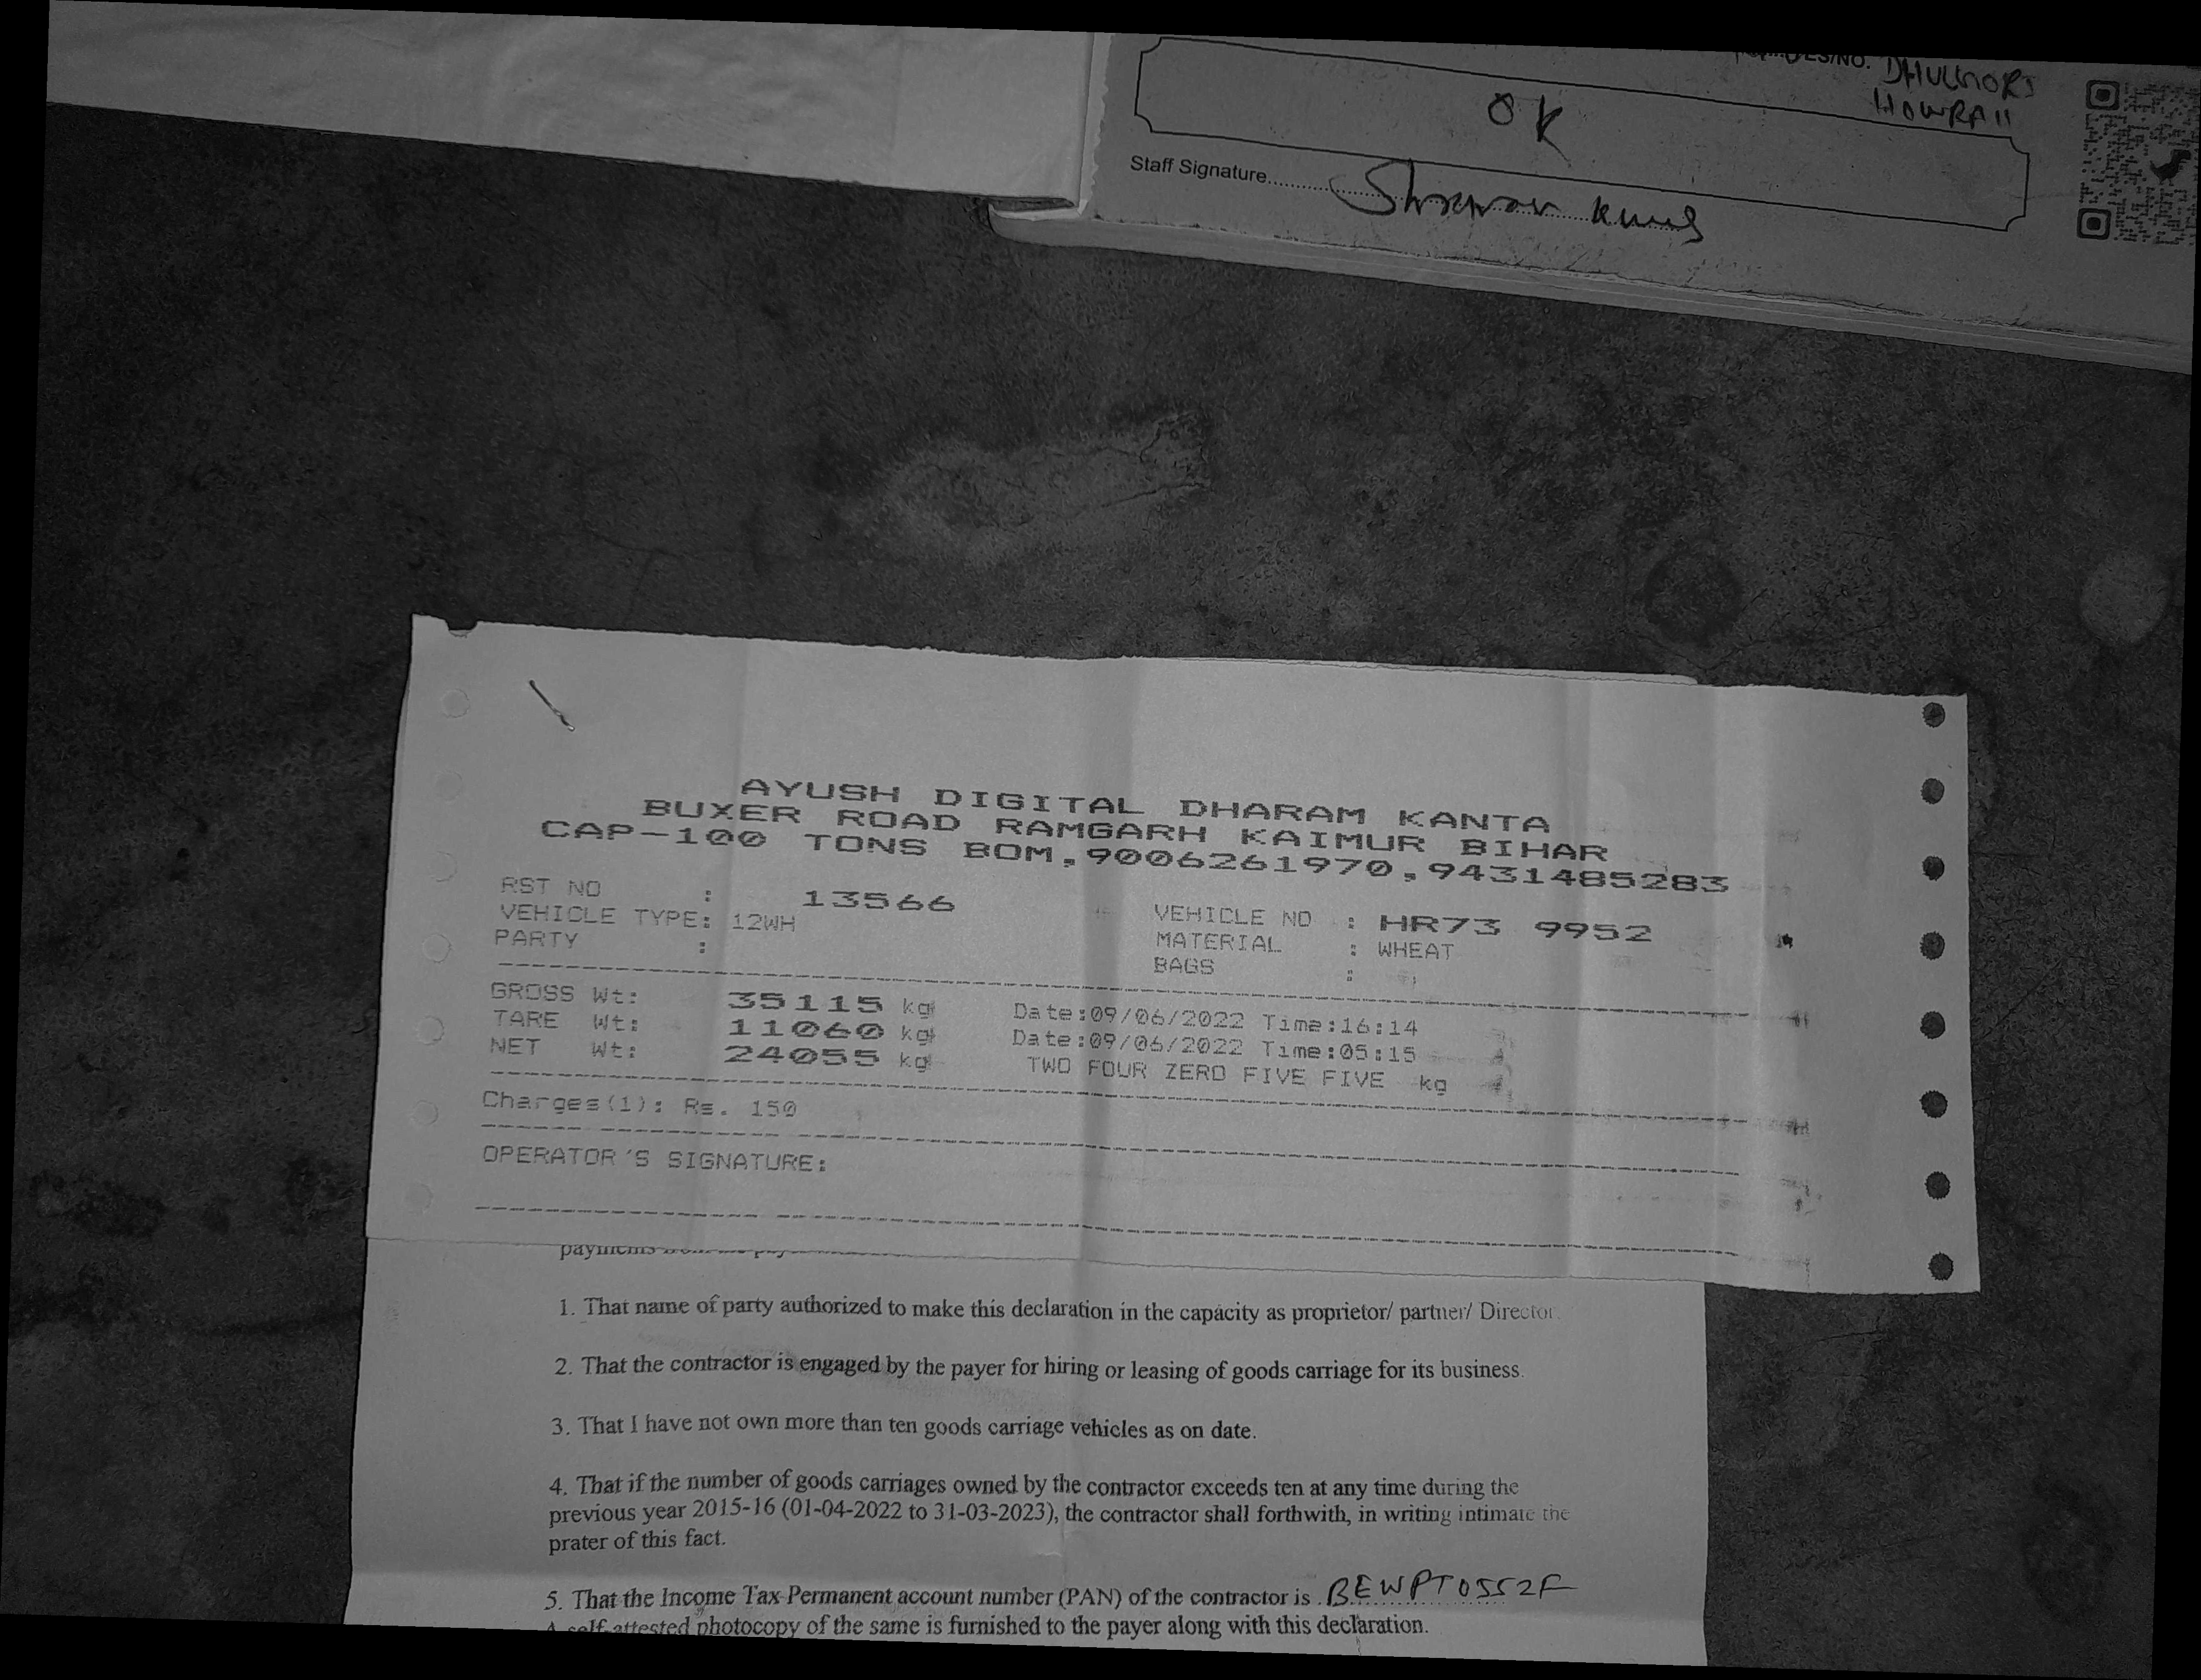

In [12]:
fixed_img = rectify_image(path=imgpaths[0], debug=False)

In [70]:
# def rectify_image(path=None, tensor=None, debug=False):
#     """
#     function that takes in one image and corrects its orientation.
#     add ability to pass url, links too

#     returns fixed_image tensor

#     """
#     assert (path==None) and (tensor==None), "pass one of path or tensor"
#     if tensor:
#         org_img = tensor2pil(tensor)
#     else:
#         org_img = read_raw_image(path)

#     # classical rectify
#     t0 = time()

#     img, angle = hough_transform(org_img)
#     print(f"classical rectify done in {round(time() - t0, 2)}s")

#     # model prediction
#     t = time()
#     tensor = tensor_transform(img)
#     pred_class = model.predict(tensor)
#     pred_class = pred_class.numpy()[0]
#     print(f"model prediction done in {round(time() - t, 2)}s")

#     # final rectify
#     t = time()
#     fixed_img = img.rotate(360-label2angle[pred_class], expand=True)
#     fixed_img = remove_padding(fixed_img)
#     print(f"final rectify done in {round(time() - t, 2)}s")

#     print(f"Total skew_correction done in {round(time() - t0, 2)}s")
#     print(f"========================================================")

#     if debug==True:
#         fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 16))
#         axes[0].imshow(pil2np(org_img))
#         axes[0].set_title("original image")
#         axes[1].imshow(pil2np(img))
#         axes[1].set_title(f"after hough {round(angle, 2)}")
#         axes[2].imshow(tensor.numpy().transpose(1, 2, 0))
#         axes[2].set_title(f"model says this img is : {pred_class}")
#         axes[3].imshow(pil2np(fixed_img))
#         axes[3].set_title(f"final image")
#         plt.tight_layout()

#         # Display the figure with subplots
#         plt.show()

#     return fixed_img

In [74]:
def predict_onebyone_in_dir(folder='../data/rotated/predict/', debug=True, max=10, save_to_dir=False, shuffle=False):
    
    imgpaths = get_images_in_dir(folder, return_path=True, shuffle=shuffle)

    for idx, path in enumerate(imgpaths):
        if idx>max:
            break
        
        output_file = os.path.join(root_dir, "data/fixed_images/") + path.split('/')[-1]
        fixed_img = rectify_image(path, debug=debug)

        t = time()
        if save_to_dir:
            fixed_img.save(output_file)
            print(f"saving done in {round(time() - t, 2)}s")
            print(f"saved to {output_file}")


classical rectify done in 0.09s
model prediction done in 0.07s
final rectify done in 0.0s
Total skew_correction done in 0.16s


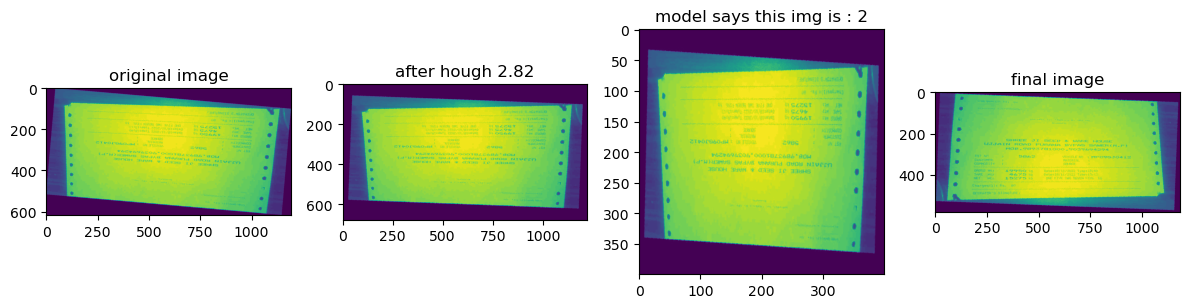

classical rectify done in 0.16s
model prediction done in 0.06s
final rectify done in 0.01s
Total skew_correction done in 0.23s


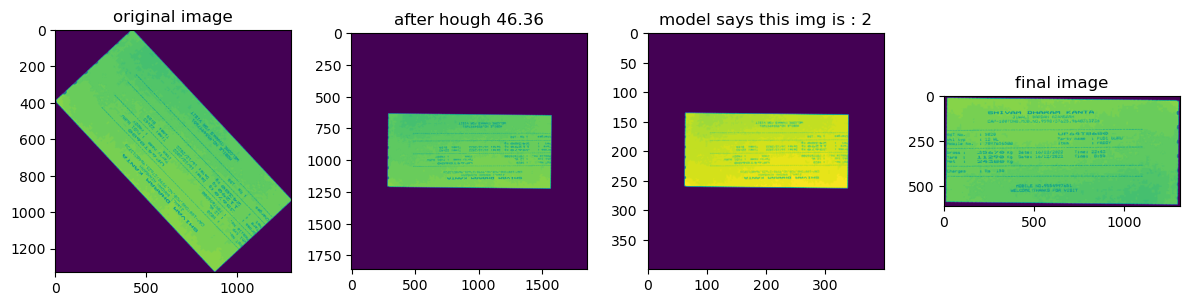

classical rectify done in 0.07s
model prediction done in 0.05s
final rectify done in 0.0s
Total skew_correction done in 0.12s


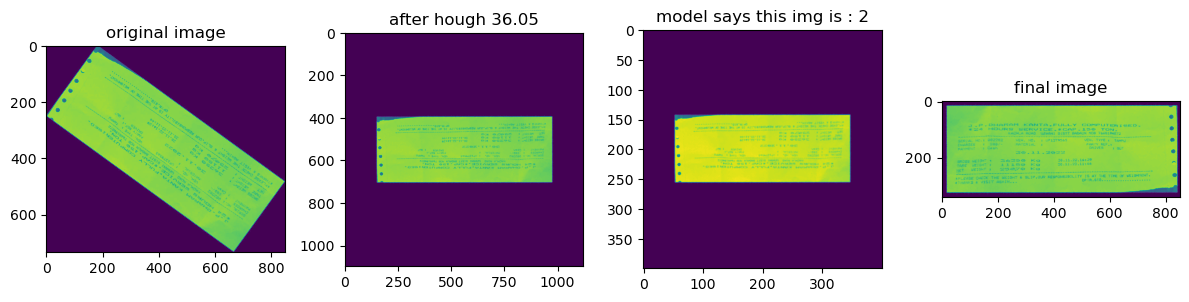

classical rectify done in 0.39s
model prediction done in 0.06s
final rectify done in 0.01s
Total skew_correction done in 0.46s


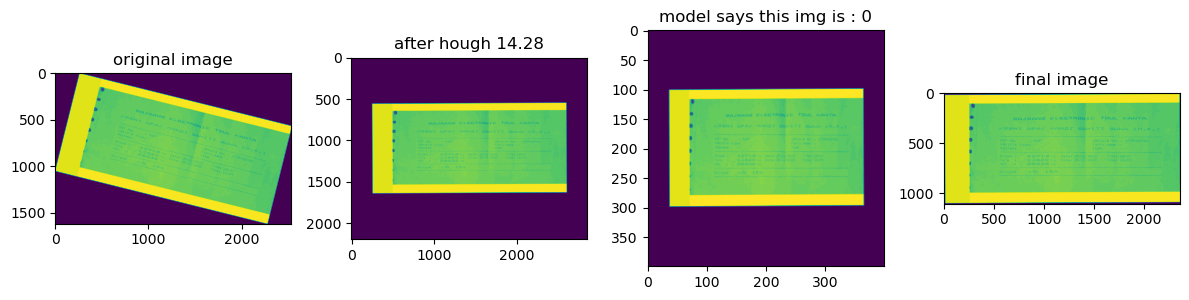

classical rectify done in 3.0s
model prediction done in 0.14s
final rectify done in 0.13s
Total skew_correction done in 3.26s


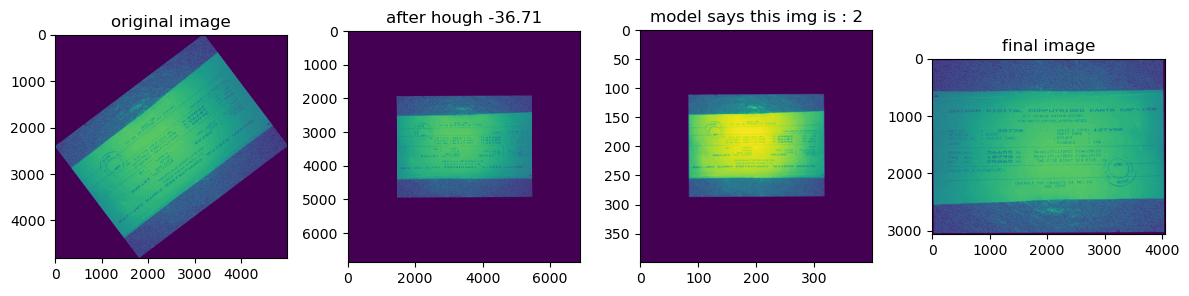

classical rectify done in 0.23s
model prediction done in 0.07s
final rectify done in 0.01s
Total skew_correction done in 0.3s


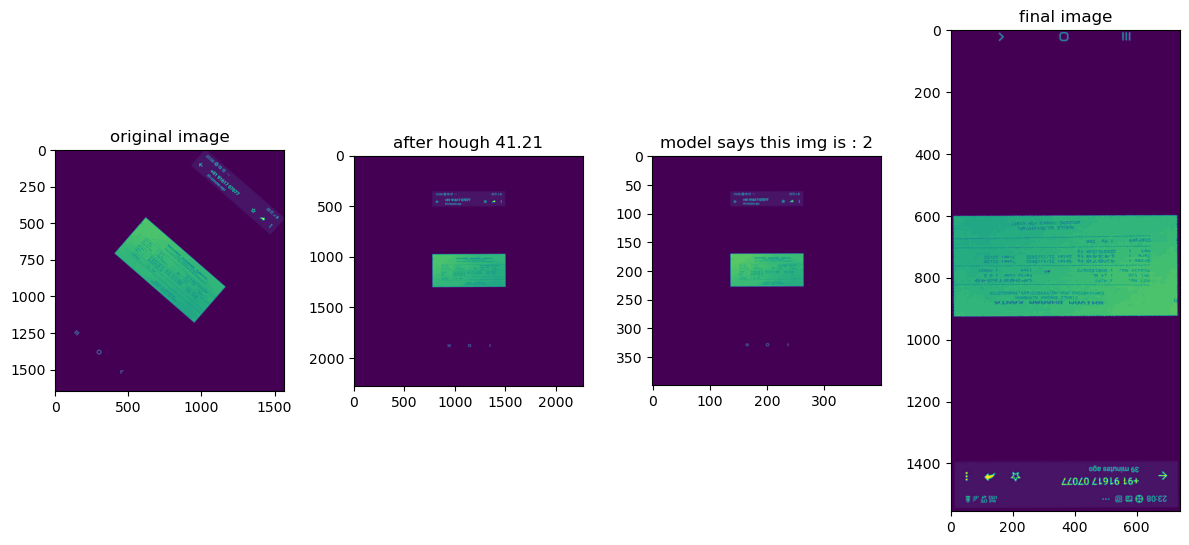

classical rectify done in 1.79s
model prediction done in 0.08s
final rectify done in 0.06s
Total skew_correction done in 1.93s


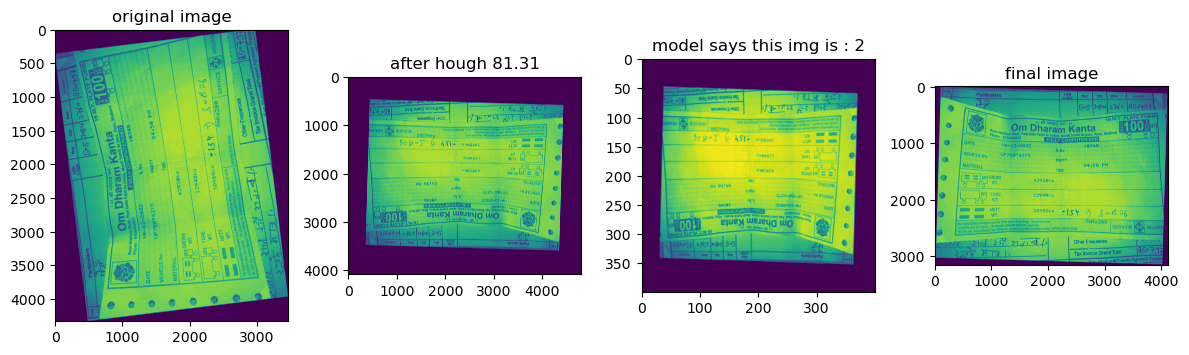

classical rectify done in 0.1s
model prediction done in 0.05s
final rectify done in 0.0s
Total skew_correction done in 0.16s


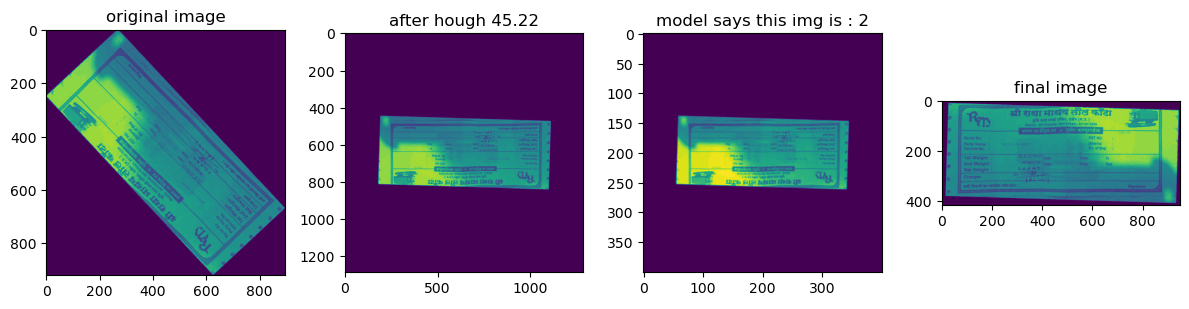

classical rectify done in 1.92s
model prediction done in 0.09s
final rectify done in 0.04s
Total skew_correction done in 2.05s


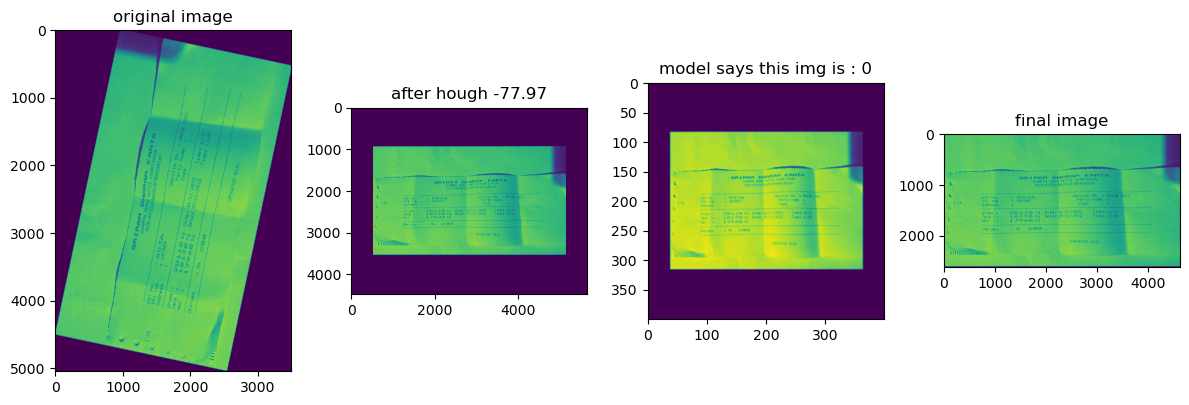

classical rectify done in 0.12s
model prediction done in 0.05s
final rectify done in 0.0s
Total skew_correction done in 0.17s


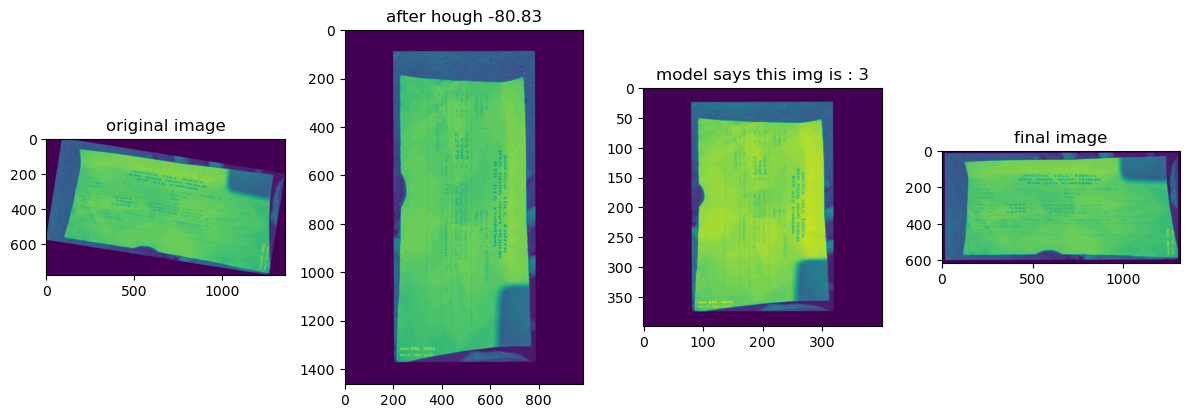

classical rectify done in 1.52s
model prediction done in 0.09s
final rectify done in 0.07s
Total skew_correction done in 1.68s


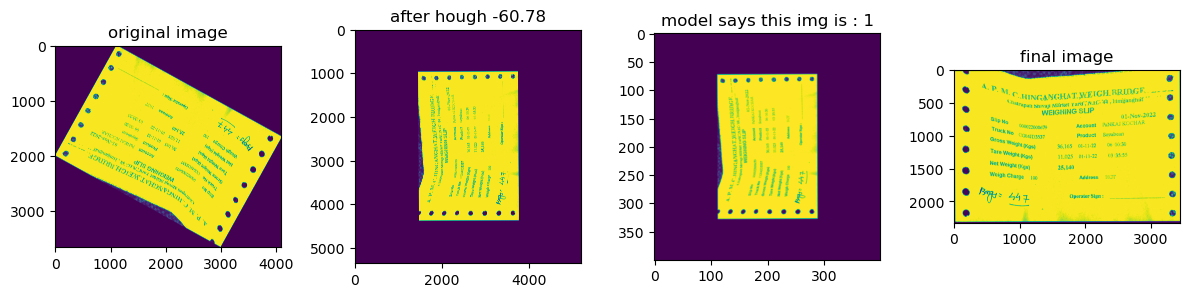

In [77]:
res = predict_onebyone_in_dir(
    folder="/home/deepam_minda_farmart_co/fmt/document-alignment-detection/document_alignment_correction/data/rotated_images/test",
    max=10,
    save_to_dir=False,
    shuffle=False,
    debug=True
)
# predict_single_tensor(tensor)

In [ ]:
def test_onebyone_in_dir():
    imgpaths = get_images_in_dir(folder, return_path=True, shuffle=shuffle)

    for idx, path in enumerate(imgpaths):
        if idx>max:
            break